In [1]:
!pip install dfply
import pandas as pd
import numpy as np
import math
from dfply import *
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import statistics 
import plotly.graph_objects as go
from scipy import stats
from scipy.stats import pearsonr
import plotly.graph_objects as go
import warnings
from scipy.stats import shapiro
from datetime import date, timedelta

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [0]:
players = pd.read_pickle('/content/drive/My Drive/Capstone/Data/Clean/Players_Clean.pkl')
players = players[players.sofifa_id.notnull()]
players.sofifa_id = players.sofifa_id.astype("int")

In [0]:
markval = pd.read_pickle("/content/drive/My Drive/Capstone/Data/Clean/markval_detailed.pkl")
stats_wide = pd.read_pickle("/content/drive/My Drive/Capstone/Data/Clean/player_stats_wide.pkl")
st_sofifa = pd.read_pickle("/content/drive/My Drive/Capstone/Data/Clean/by_position_sofifa/strikers_Clean.pkl")
wg_sofifa = pd.read_pickle("/content/drive/My Drive/Capstone/Data/Clean/by_position_sofifa/wingers_Clean.pkl")

In [0]:
def merge_all(df_sofifa, players, markval, stats):
  merged_sofifa = pd.merge(df_sofifa, players[["tm_id","sofifa_id"]])
  merged_sofifa = pd.merge(merged_sofifa, markval, on = ["tm_id","year"])
  no_mv_cols = (merged_sofifa.select_dtypes(include=['float64']) >> select(~X.mv)).columns.tolist()
  no_mv_cols.insert(0, "mv")
  df_sofifa_floats = merged_sofifa[no_mv_cols]
  df_sofifa_stats = pd.merge(merged_sofifa, stats, on = ["tm_id","year"])
  sofifa_cols = df_sofifa.select_dtypes("float64").columns.tolist()
  sofifa_cols.insert(0, "mv")
  return merged_sofifa,df_sofifa_floats,df_sofifa_stats,sofifa_cols
  
def pair_plot(df,h = 900,w = 900):
  col_name = lambda x : x.split("_")[0][0:2] + "_" + x.split("_")[1][0:2] if len(x.split("_")) > 1 else x
  fig = px.scatter_matrix(df,labels=
                        {col: col_name(col) for col in df.columns},
                        height = h, width = w
                        )
  fig.update_traces(diagonal_visible=False)
  # fig.show()
  col_abbrs = {
      "column_abbr" : list(map(col_name, df.columns)),
      "column_name" : df.columns
  }
  return fig, pd.DataFrame(col_abbrs)

def heat_map(df, diagonal = "upper", w = 30,h = 20):
  df = df.select_dtypes(include=['float64'])
  corr = df.corr()
  plt.figure(figsize = (w, h))
  if(diagonal == "lower"):
    mask = np.triu(np.ones_like(corr, dtype=np.bool))
    ax = sns.heatmap(corr, annot = True, linewidths=.5, mask = mask)
  elif(diagonal == "upper"):
    mask = np.tril(np.ones_like(corr, dtype=np.bool))
    ax = sns.heatmap(corr, annot = True, linewidths=.5, mask = mask)
  else:
    ax = sns.heatmap(corr, annot = True, linewidths=.5)
  ax.tick_params(right=True, top=True, labelright=True, labeltop=True)
  plt.show()
  return plt

def get_columns(df,cumulative):
  if(cumulative):
    cols = (df >> select(starts_with('cum'))).columns.tolist()
  else:
    cols = (df >> select(~starts_with('cum'))).columns.tolist()
  return cols

In [0]:
st_sofifa, st_sofifa_floats, st_sofifa_stats, st_sofifa_cols = merge_all(st_sofifa, players,markval,stats_wide)
wg_sofifa, wg_sofifa_floats, wg_sofifa_stats, wg_sofifa_cols = merge_all(wg_sofifa, players,markval,stats_wide)

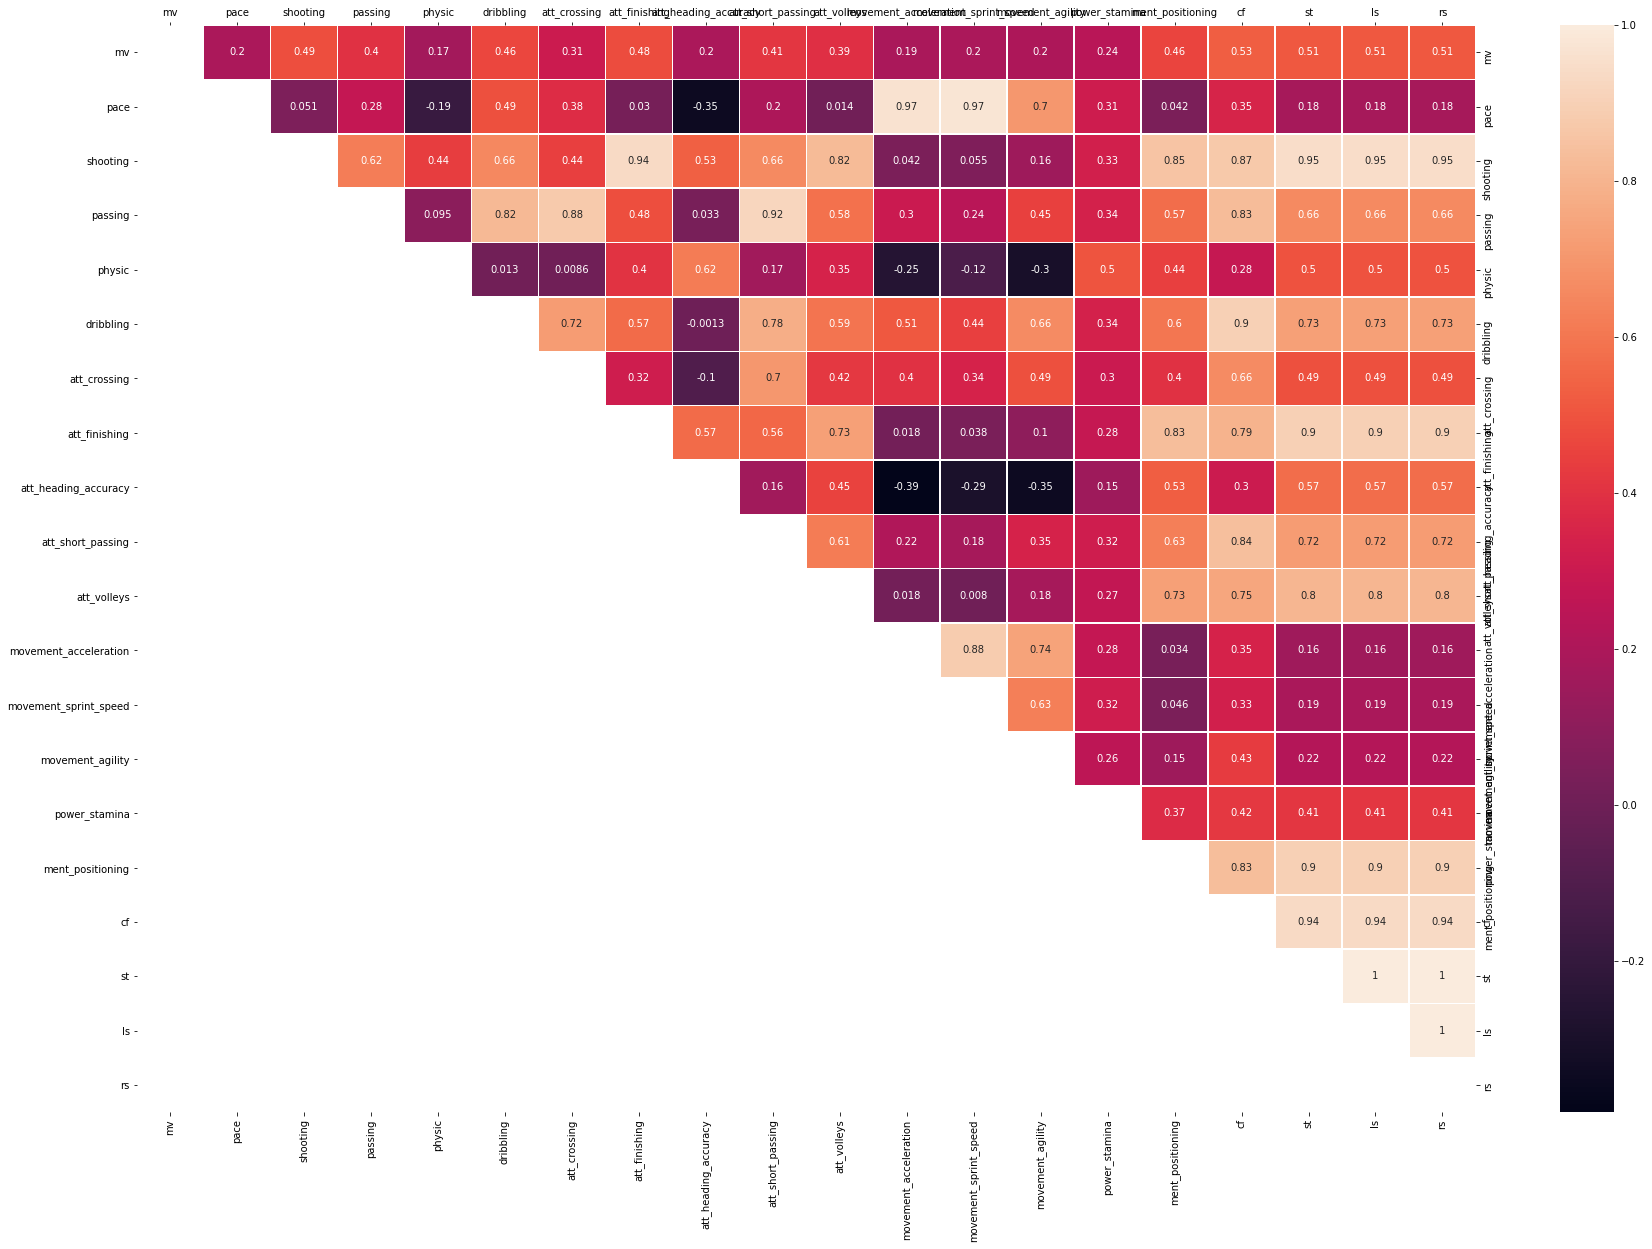

In [8]:
hm_df = st_sofifa_stats[st_sofifa_cols]
cols = hm_df.columns
cols = [col.replace("defending","def") for col in cols ]
cols = [col.replace("attacking","att") for col in cols ]
cols = [col.replace("mentality","ment") for col in cols ]
hm_df.columns = cols
st_hm = heat_map(hm_df, "upper")

The variables that have the highest correlation with the player's market value are positioning, dribbling, shooting and finishing. Pace, heading and sprint speed attributes seem to have the least correlation.

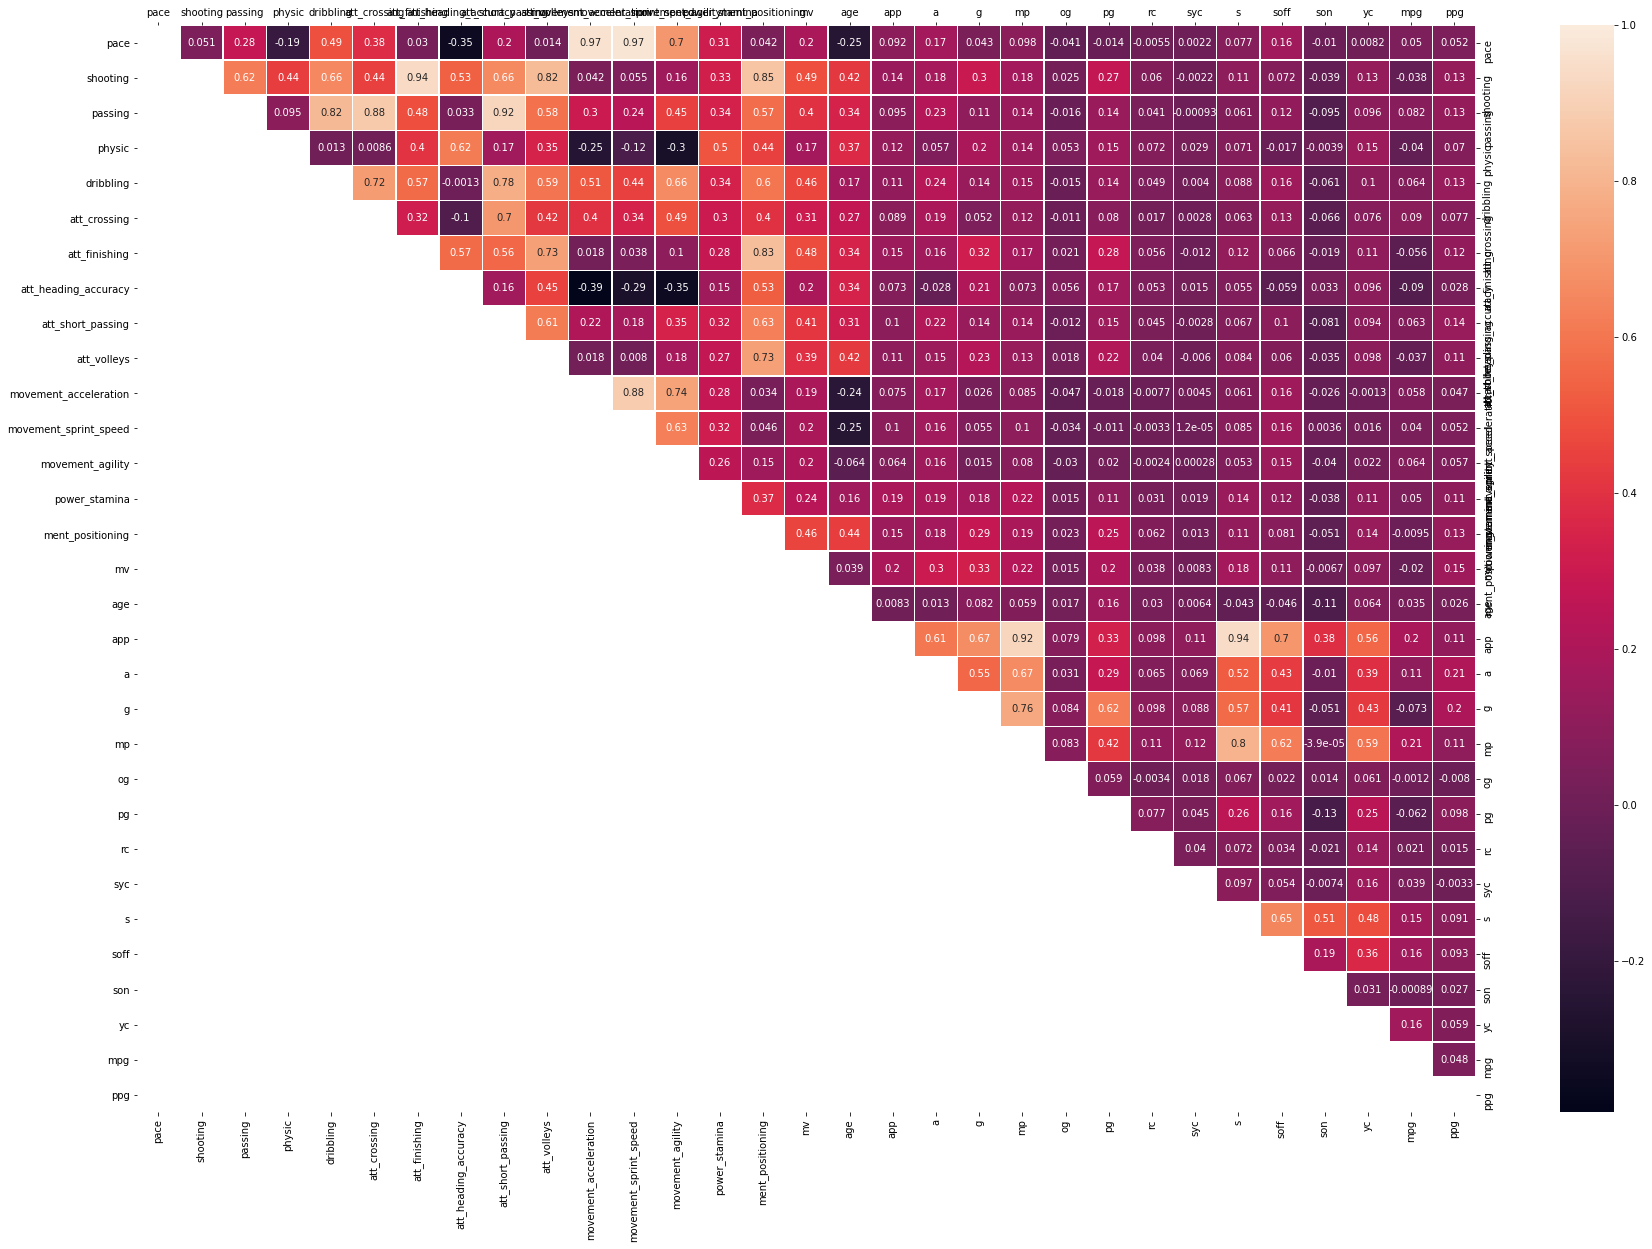

In [9]:
cols = st_sofifa_stats.columns
cols = [col.replace("defending","def") for col in cols ]
cols = [col.replace("attacking","att") for col in cols ]
cols = [col.replace("mentality","ment") for col in cols ]
st_sofifa_stats.columns = cols
non_cum = get_columns(st_sofifa_stats, cumulative = False)
st_hm = heat_map(st_sofifa_stats[non_cum] >> select(~X.cf, ~X.st, ~X.ls, ~X.rs),"upper")

The goals are correlated to shooting and finishing abilities, and the assists are correlated to passing and dribbling.

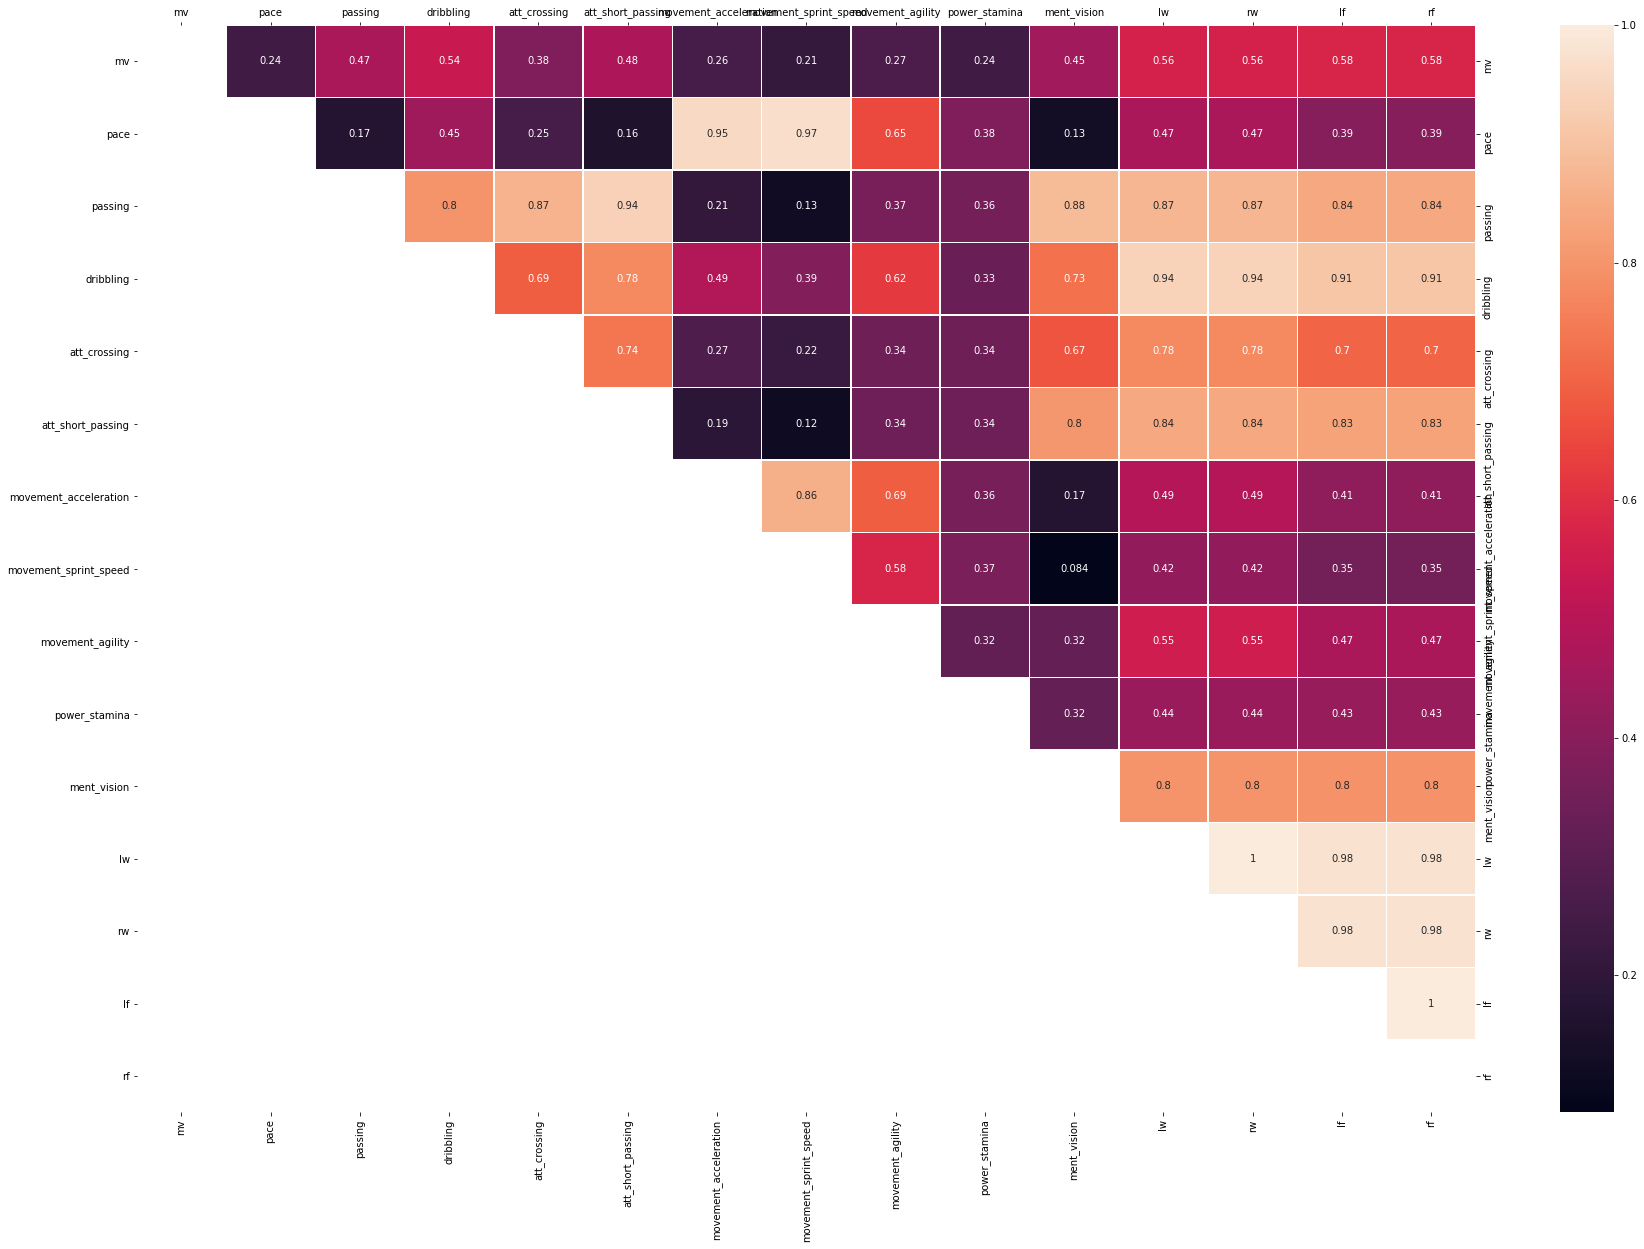

In [10]:
hm_df = wg_sofifa_stats[wg_sofifa_cols]
cols = hm_df.columns
cols = [col.replace("defending","def") for col in cols ]
cols = [col.replace("attacking","att") for col in cols ]
cols = [col.replace("mentality","ment") for col in cols ]
hm_df.columns = cols
wg_hm = heat_map(hm_df, "upper")

For wingers, dribbling has the highest correlation with market value,with passing and vision also being relatively strongly correlated. Crossing also has a little bit higher correlation, whereas agility speed and pace attributes have the least correlation, however these attributes have the highest correlation to market value in comparison with other positions, as speed is generally one of the most important attributes for a winger.

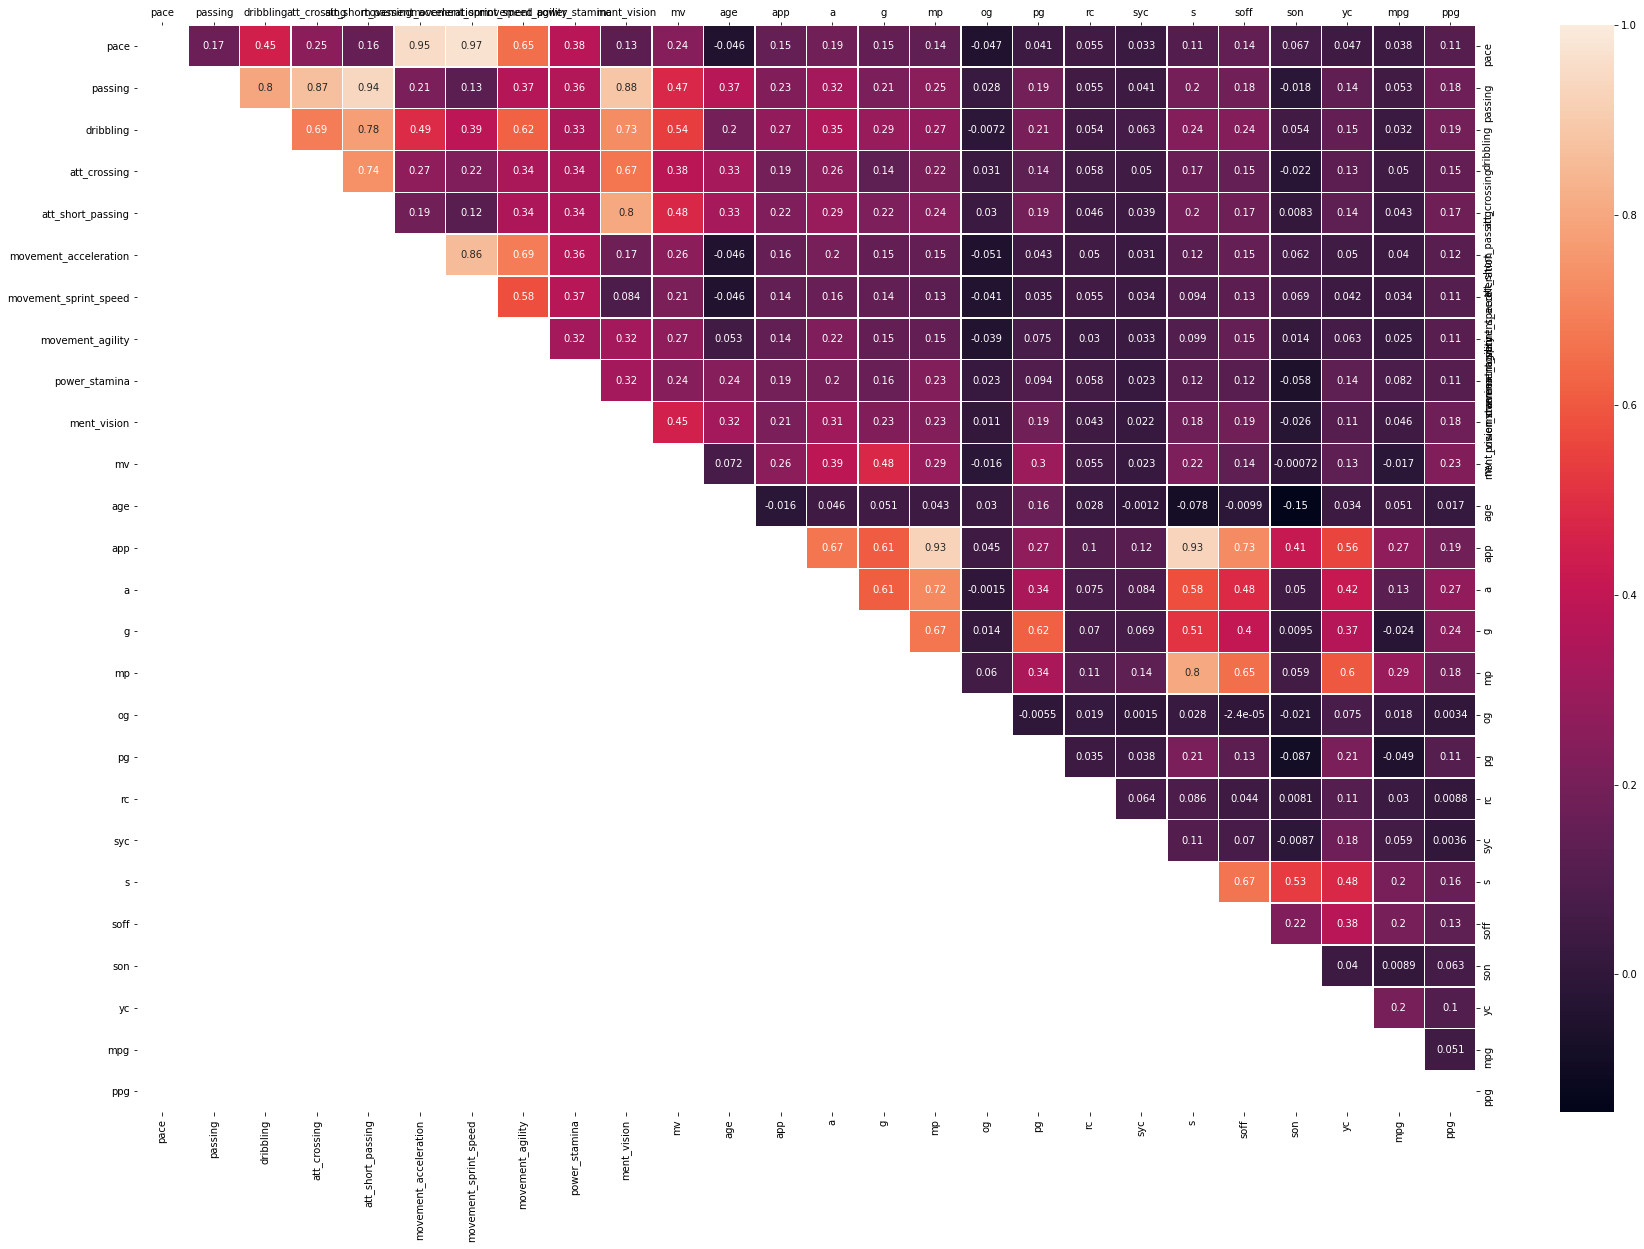

In [12]:
cols = wg_sofifa_stats.columns
cols = [col.replace("defending","def") for col in cols ]
cols = [col.replace("attacking","att") for col in cols ]
cols = [col.replace("mentality","ment") for col in cols ]
wg_sofifa_stats.columns = cols
non_cum = get_columns(wg_sofifa_stats, cumulative = False)
st_hm = heat_map(wg_sofifa_stats[non_cum] >> select(~X.lw, ~X.rw, ~X.lf, ~X.rf),"upper")

Again the same situation with goals and assists. Minutes played is also correlated to dribbling and ability, however the opposite statstics which is the number of times player was substituted off the pitch is also correlated to the player's dribbling ability. Just like midfielders' case the player's with good dribbling skills play more individually, thus leading to more chances of losing the ball for the team.